In [ ]:
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
nltk.download("all")
from bs4 import BeautifulSoup
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import seed_everything
from tqdm import tqdm
from pytorch_lightning.callbacks import TQDMProgressBar
import torchmetrics
from torchmetrics.functional.classification import binary_accuracy, binary_f1_score, binary_precision, binary_recall, binary_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA TITAN RTX


In [9]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [10]:
# drop the rows with neutral sentiment as we are only interested in positive and negative sentiment
train = train[train['sentiment'] != 'neutral']
train = train.reset_index(drop=True)

test = test[test['sentiment'] != 'neutral']
test = test.reset_index(drop=True)

#re-arranging the datasets
train = train[['text','sentiment']]
test = test[['text','sentiment']]

#sentiment converter funtion
def sentiment_ts(sentiment):
    if sentiment == 'negative':
        return 0
    elif sentiment == 'positive':
        return 1

#convert the text sentimnet into number
train['label'] = train['sentiment'].apply(sentiment_ts)
test['label'] = test['sentiment'].apply(sentiment_ts)

#final dataset
train = train[['text','label']]
test = test[['text','label']]

# #sanity check
# train.head()
# test.head()
# train.isnull().sum()
# test.isnull().sum()

In [11]:
#load the spacy model and functions related to stop words modification
spacy_model = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
# print(spacy_model.Defaults.stop_words) #print the default stop words list
# spacy_model.Defaults.stop_words.remove("whatever") #remove single stop word from the list
# spacy_model.Defaults.stop_words -= {"whatever", "whenever"} #remove several stop words from the list
# spacy_model.Defaults.stop_words.add("my_new_stopword") #add single stop word in the default list
# spacy_model.stop_words |= {"my_new_stopword1","my_new_stopword2"} #add several stop words in the default list

In [12]:
#most widely used shortforms are in the internet for social media data
contra_Expan_Dict = {
"ain`t": "am not","aren`t": "are not","can`t": "cannot","can`t`ve": "cannot have","`cause": "because",
"could`ve": "could have","couldn`t": "could not","couldn`t`ve": "could not have","didn`t": "did not",
"doesn`t": "does not","don`t": "do not","hadn`t": "had not","hadn`t`ve": "had not have","hasn`t": "has not",
"haven`t": "have not","he`d": "he would","he`d`ve": "he would have","he`ll": "he will","he`ll`ve": "he will have",
"he`s": "he is","how`d": "how did","how`d`y": "how do you","how`ll": "how will",
"how`s": "how does","i`d": "i would","i`d`ve": "i would have","i`ll": "i will","i`ll`ve": "i will have","i`m": "i am",
"i`ve": "i have","isn`t": "is not","it`d": "it would","it`d`ve": "it would have","it`ll": "it will","it`ll`ve": "it will have",
"it`s": "it is","let`s": "let us","ma`am": "madam","mayn`t": "may not","might`ve": "might have","mightn`t": "might not",
"mightn`t`ve": "might not have","must`ve": "must have","mustn`t": "must not","mustn`t`ve": "must not have","needn`t": "need not","needn`t`ve": "need not have",
"o`clock": "of the clock","oughtn`t": "ought not","oughtn`t`ve": "ought not have","shan`t": "shall not",
"sha`n`t": "shall not","shan`t`ve": "shall not have","she`d": "she would",
"she`d`ve": "she would have","she`ll": "she will","she`ll`ve": "she will have",
"she`s": "she is","should`ve": "should have","shouldn`t": "should not","shouldn`t`ve": "should not have","so`ve": "so have","so`s": "so is",
"that`d": "that would","that`d`ve": "that would have","that`s": "that is","there`d": "there would","there`d`ve": "there would have","there`s": "there is",
"they`d": "they would","they`d`ve": "they would have","they`ll": "they will","they`ll`ve": "they will have","they`re": "they are","they`ve": "they have",
"to`ve": "to have","wasn`t": "was not"," u ": " you "," ur ": " your "," n ": " and ","won`t": "would not",
"dis": "this","bak": "back","brng": "bring","sooo": "so", "afaik" :"as far as i know",
"afk" :"away from keyboard","asap" :"as soon as possible","atk" :"at the keyboard","atm" :"at the moment","a3" :"anytime, anywhere, anyplace",
"bak" :"back at keyboard","bbl" :"be back later","bbs" :"be back soon","bfn" :"bye for now","b4n" :"bye for now","brb" :"be right back",
"brt" :"be right there","btw" :"by the way","b4" :"before","b4n" :"bye for now","cu" :"see you","cul8r" :"see you later",
"cya" :"see you","faq" :"frequently asked questions","fc" :"fingers crossed","fwiw" :"for what it's worth","fyi" :"for your information",
"gal" :"get a life","gg" :"good game","gn" :"good night","gmta" :"great minds think alike","gr8" :"great!","g9" :"genius",
"ic" :"i see","icq" :"i seek you (also a chat program)","ilu" :"ilu: i love you","imho" :"in my honest/humble opinion","imo" :"in my opinion","iow" :"in other words",
"irl" :"in real life","kiss" :"keep it simple, stupid","ldr" :"long distance relationship","lmao" :"laugh my a.. off","lol" :"laughing out loud",
"ltns" :"long time no see","l8r" :"later","mte" :"my thoughts exactly","m8" :"mate","nrn" :"no reply necessary","oic" :"oh i see",
"pita" :"pain in the a..","prt" :"party","prw" :"parents are watching","qpsa?   que pasa?" :"","rofl" :"rolling on the floor laughing",
"roflol" :"rolling on the floor laughing out loud","rotflmao" :"rolling on the floor laughing my ass off","sk8" :"skate","stats" :"your sex and age",
"asl" :"age, sex, location","thx" :"thank you","ttfn" :"ta-ta for now!","ttyl" :"talk to you later",
"u" :"you","u2" :"you too","u4e" :"yours for ever","wb" :"welcome back","wtf" :"what the fuck","wtg" :"way to go!",
"wuf" :"where are you from?","w8" :"wait","7k" :"sick:-d laugher", "w/out": "without", "ihavent": "i have not"}

In [13]:
#function for converting shortforms to it's expanded form based on contra_Expan_Dict
def expanded_form(x):
  if x in contra_Expan_Dict.keys():
    return(contra_Expan_Dict[x])
  else:
    return(x)

#function for removing url punctuations and digits
def clean_with_re(x):
  x=str(x)
  x=re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ", x) #Remove URLs
  x=re.sub(r'[^\w ]+', "", x) # Remove Punctuation-1
  x=re.sub(r"[,!@&\'?\.$%_]"," ", x) # Remove Punctuation-2
  x=re.sub(r"\d+"," ", x) #Remove digits
  return(x)

#function for removing HTML Tags
def remove_html(text):
    return BeautifulSoup(text, "lxml").text

#function for counting the words in the train dataset
from collections import Counter
cnt = Counter()
for text in train["text"].values:
    for word in text.split():
        cnt[word] += 1

#function for removing the most frequent words
cnt.most_common(10)
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

#function for removing the most rare words
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

#remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

#function for removing duplicate white spaces
def remove_duplicate_ws(x):
  x=str(x)
  x=" ".join(re.split("\s+", x, flags=re.UNICODE))
  return(x)

In [14]:
def pre_processing(input_data, text_col):
    #convert all the input texts into lower case.
  input_data["text_col_clean"]=input_data[text_col].apply(lambda x:str(x).lower())
  #convert all the shortform of the input texts to its expanded form.
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:[expanded_form(t) for t in str(x).split()])
  #remove the stopwords based on spacy default package
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:[t for t in x if t not in spacy_stopwords])
  #remove the url, punctuations and digits from the input text
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:clean_with_re(x))
  #remove the HTML Tags from the input text
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_html(x))
  #lemmatization - converting evary word to it's root form
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:" ".join([t.lemma_ for t in spacy_model(str(x))if t.lemma_ !="-PRON-" ]))
  #remove the most frequents words
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_freqwords(x))
  #remove the most rare words
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_rarewords(x))
  #remove the emojis
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_emoji(x))
  #remove the duplicate whitespace.
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_duplicate_ws(x))

In [15]:
#call the pre_processing function both for train and test datasets
pre_processing(input_data=train, text_col="text")
pre_processing(input_data=test, text_col="text")

In [16]:
#check random text before and after pre-processing
print("Before Pre-processing: ",train["text"][300])
print("After Pre-processing: ",train["text_col_clean"][300])
#print the sentence length before and after pre-processing
print("Before Pre-processing: ",len(train["text"][300].split()))
print("After Pre-processing: ",len(train["text_col_clean"][300].split()))
#print the sentiment of the text
print("Sentiment of the text: ",train["label"][300])

Before Pre-processing:   but my bday is JUNE 19.. this is wack... and ihavent seen any promotions for my bday party  someone better finagle this asap!
After Pre-processing:  bday june wack have not see promotion bday party well finagle asap
Before Pre-processing:  23
After Pre-processing:  12
Sentiment of the text:  0


In [17]:
# Clean dataset
train = train[['text_col_clean','label']]
test = test[['text_col_clean','label']]

# #sanity check
# train.head()
# test.head()
# train.isnull().sum()
# test.isnull().sum()

# #reduce the sample size inorder to save time for our experiment.
# train = train.sample(n=1000)
# test = test.sample(n=1000)

In [18]:
# Load train dataset and split into train and val dataset
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

In [19]:
# perparameters
learning_rate = 2e-5
max_length = 128
batch_size = 8
num_labels = 2
epochs = 10

pretrained_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
loss_fn = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
class MyDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = self.data.iloc[index]['text_col_clean'] # neec to change based on text pre-processing
        label = self.data.iloc[index]['label']
        encoding = self.tokenizer.encode_plus(
            text, 
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt')
        return encoding['input_ids'][0], encoding['attention_mask'][0], label

In [21]:
# Create datasets and data loaders for train val and test
train_dataset = MyDataset(train_data, tokenizer, max_length)
val_dataset = MyDataset(val_data, tokenizer, max_length)
test_dataset = MyDataset(test, tokenizer, max_length)


# #sanity check
# train_dataset[5]
# val_dataset[5]
# test_dataset[5]

In [22]:
class MyModel(pl.LightningModule):
    def __init__(self, num_labels, batch_size, learning_rate):
        super().__init__()
        self.model = pretrained_model
        self.num_classes = num_labels
        self.loss_function = loss_fn
        self.batch_size = batch_size
        self.learning_rate = learning_rate
           
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return output.logits
    
    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, drop_last=True)
    
    def test_dataloader(self):
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, drop_last=True)
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, label = batch
        output = self(input_ids, attention_mask)
        loss = self.loss_function(output, label)
        preds = torch.argmax(output, dim=1)
        
        #matrix calculation
        accuracy = binary_accuracy(preds, label)
        # f1_score = binary_f1_score(preds, label)
        # recall = binary_recall(preds, label)
        # precision = binary_precision(preds, label)
        
        #log the metrics
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", accuracy, prog_bar=True, logger=True)
        # self.log("train_f1", f1_score, prog_bar=True, logger=True)
        # self.log("train_recall", recall, prog_bar=True, logger=True)
        # self.log("train_precision", precision, prog_bar=True, logger=True)
        return {"train_loss":loss, "train_accuracy":accuracy}

           
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, label = batch
        output = self(input_ids, attention_mask)
        loss = self.loss_function(output, label)
        preds = torch.argmax(output, dim=1)
        
        #matrix calculation
        accuracy = binary_accuracy(preds, label)
        # f1_score = binary_f1_score(preds, label)
        # recall = binary_recall(preds, label)
        # precision = binary_precision(preds, label)
        
        #log the metrics
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", accuracy, prog_bar=True, logger=True)
        # self.log("val_f1", f1_score, prog_bar=True, logger=True)
        # self.log("val_recall", recall, prog_bar=True, logger=True)
        # self.log("val_precision", precision, prog_bar=True, logger=True)
        return {"val_loss":loss, "val_accuracy":accuracy}

    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, label = batch
        output = self(input_ids, attention_mask)
        loss = self.loss_function(output, label)
        preds = torch.argmax(output, dim=1)
        
        #matrix calculation
        accuracy = binary_accuracy(preds, label)
        f1_score = binary_f1_score(preds, label)
        recall = binary_recall(preds, label)
        precision = binary_precision(preds, label)
        confusion_matrix = binary_confusion_matrix(preds, label)
        confusion_matrix = confusion_matrix.cpu().detach().numpy()
        
        #plot confusion matrix        
        df_cm = pd.DataFrame(confusion_matrix, index = range(2), columns=range(2))
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
    
        #log the metrics
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", accuracy, prog_bar=True, logger=True)
        self.log("test_f1", f1_score, prog_bar=True, logger=True)
        self.log("test_recall", recall, prog_bar=True, logger=True)
        self.log("test_precision", precision, prog_bar=True, logger=True)
        self.logger.experiment.add_figure('confusion matrix', fig_, global_step=self.current_epoch)
        return {"test_loss":loss, "test_accuracy":accuracy}
          
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': lr_scheduler,
            'monitor': 'val_loss'
        }

In [28]:
#ensure full reproducibility from run to run
seed_everything(42, workers=True)
model = MyModel(num_labels, batch_size, learning_rate)

# Load the best model checkpoint
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath='./best_model/',
    filename='best_model'
)

# Custom loager. By default lightning_logs are generated. if you want to pass the custom logger then you have the pass logger=logger inside the trainer.
# logger = TensorBoardLogger("logs/", name="my_experiment")

# Early stoping
# early_stop_callback = EarlyStopping(monitor="val_acc", min_delta=0.00, patience=3, verbose=False, mode="max")

trainer = pl.Trainer(max_epochs=epochs, gpus=1, 
                     callbacks=[checkpoint_callback, LearningRateMonitor(), TQDMProgressBar(refresh_rate=5)], auto_lr_find=True, deterministic=True, auto_scale_batch_size=True)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
# fine the batch size automatically and update the model
new_batch_size = trainer.tuner.scale_batch_size(model, mode='power')
model.batch_size = new_batch_size

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 succeeded, trying batch size 64
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 64 succeeded, trying batch size 128
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 128 succeeded, trying batch size 256
Batch size 256 failed, trying batch size 128
Finished batch size finder, will continue with full run using batch size 128
Restoring states from the checkpoint path at /home/gist/wahid/.scale_batch_size_6d90c6d8-2885-475a-b036-7619bc718756.ckpt
Restored all states from the checkpoint file at /home/gist/wahid/.scal

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Restoring states from the checkpoint path at /home/gist/wahid/.lr_find_0715c713-151f-4eaf-bbfb-b4cb957e43ee.ckpt
Restored all states from the checkpoint file at /home/gist/wahid/.lr_find_0715c713-151f-4eaf-bbfb-b4cb957e43ee.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

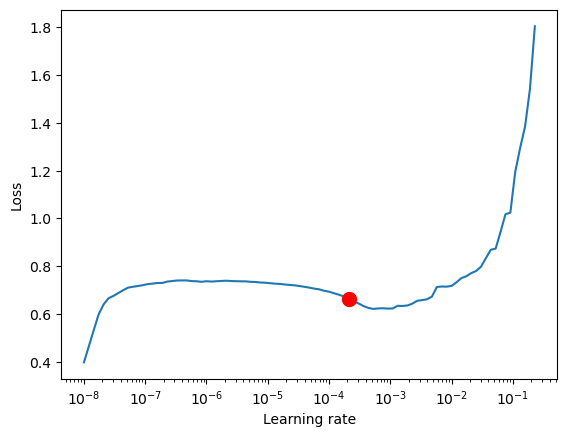

In [30]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [31]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print("new learning rate: ", new_lr)

# # update hparams of the model
# model.hparams.lr = new_lr

#updat the learning rate of the model
model.configure_optimizers = lambda: optim.Adam(model.parameters(), lr=new_lr)

new learning rate:  0.0002089296130854041


In [32]:
# Training: This is the basic use of the trainer
trainer.fit(model, model.train_dataloader(), model.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                          | Params
----------------------------------------------------------------
0 | model         | BertForSequenceClassification | 109 M 
1 | loss_function | CrossEntropyLoss              | 0     
----------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [33]:
# Validation: Perform an evaluation epoch over the validation set, outside of the training loop
trainer.validate(model, model.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy          0.8628125190734863
        val_loss            0.5318986773490906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.5318986773490906, 'val_accuracy': 0.8628125190734863}]

In [34]:
# Load the best model checkpoint for testing
best_model = MyModel.load_from_checkpoint(checkpoint_callback.best_model_path, num_labels=num_labels, batch_size=batch_size, learning_rate=learning_rate)

# Test the model using the test loader
trainer.test(best_model, model.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy            0.89794921875
         test_f1            0.9012746810913086
        test_loss           0.2594478130340576
     test_precision         0.9016696214675903
       test_recall           0.902188777923584
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2594478130340576,
  'test_accuracy': 0.89794921875,
  'test_f1': 0.9012746810913086,
  'test_recall': 0.902188777923584,
  'test_precision': 0.9016696214675903}]

In [1]:
# run this "tensorboard --logdir=lightning_logs/" in the terminal to see the logs